## ANALISIS DENUNCIAS POR VIOLENCIA DE GÉNERO EN ESPAÑA

In [1]:
import pandas as pd
import pylab as plt
import seaborn as sns


In [2]:
fest  = pd.read_csv('../data_clean/scrapeo/festivos_provincia.csv')
norm = pd.read_csv('../data_clean/scrapeo/normativas.csv')
denu = pd.read_csv('../data_clean/portal_estadistico_vio_gen/denuncias.csv')
llam = pd.read_csv('../data_clean/portal_estadistico_vio_gen/llamadas016.csv')
ord = pd.read_csv('../data_clean/portal_estadistico_vio_gen/ordenes_prot.csv')
disp = pd.read_csv('../data_clean/portal_estadistico_vio_gen/dispositivos.csv')
men = pd.read_csv('../data_clean/portal_estadistico_vio_gen/menores.csv')
vic = pd.read_csv('../data_clean/portal_estadistico_vio_gen/victimas_mortales.csv')
sent = pd.read_csv('../data_clean/ine/sentencias.csv')
tipos = pd.read_csv('../data_clean/ine/tipos_violencias.csv')
cond = pd.read_csv('../data_clean/ine/condenados_edad.csv')
salud = pd.read_csv('../data_clean/ine/salud_mental.csv')
paro = pd.read_csv('../data_clean/ine/tasa_actividad.csv')
alcohol = pd.read_csv('../data_clean/ine/alcohol.csv')
educ = pd.read_csv('../data_clean/ine/nivel_educativo.csv')
total_prov = pd.read_csv('../data_clean/ine/total_prov.csv')
total_ccaa = pd.read_csv('../data_clean/ine/total_ccaa.csv')

In [3]:
denu.describe(include='object').T

,count,unique,top,freq
trimestre,21112,4,primero,5460
origen_denuncia,21112,7,victima,3016
provincia,21112,51,cuenca,812
comunidad,21112,18,castilla y leon,3654


In [4]:
denu.describe()

,año,total_denuncias
count,21112.000000,21112.000000
mean,2015.758621,101.750616
std,4.190854,305.210568
min,2009.000000,0.000000
25%,2012.000000,1.000000
50%,2016.000000,9.000000
75%,2019.000000,67.000000
max,2023.000000,5392.000000


In [5]:
mujeres_prov = total_prov[total_prov['sexo'] == 'mujeres']
mujeres_prov = mujeres_prov.sort_values(by=['año', 'provincia'])
mujeres_prov  # Población total de mujeres por año y provincia

,provincia,sexo,año,total
47,alava,mujeres,2007,153419
102,albacete,mujeres,2007,195338
103,alicante,mujeres,2007,911809
101,almeria,mujeres,2007,313406
26,asturias,mujeres,2007,559570
...,...,...,...,...
1496,valencia,mujeres,2021,1321351
1507,valladolid,mujeres,2021,266518
1530,vizcaya,mujeres,2021,596918
1552,zamora,mujeres,2021,85174


In [6]:
denu.head()

,año,trimestre,origen_denuncia,provincia,comunidad,total_denuncias
0,2009,primero,victima,almeria,andalucia,40
1,2009,primero,familiar,almeria,andalucia,1
2,2009,primero,policia_victima,almeria,andalucia,419
3,2009,primero,policia_familiar,almeria,andalucia,7
4,2009,primero,intervencion_policial_directa,almeria,andalucia,82


COMBINACION DENUNCIAS POR VG CON POBLACION TOTAL DE MUJERES

In [7]:
denu_filtrado = denu.groupby(['año', 'provincia'], as_index=False)['total_denuncias'].sum()
denu_filtrado.head()

,año,provincia,total_denuncias
0,2009,alava,740
1,2009,albacete,959
2,2009,alicante,7757
3,2009,almeria,2604
4,2009,asturias,2373


In [8]:
# Primero vamos a unir los df de denuncias y de poblacion total de mujeres:
denu_combi = pd.merge(denu_filtrado, mujeres_prov, on=['año', 'provincia'], how='left')

# Ahora vamos a obtener la tasa de denuncias por cada 1000 mujeres:
denu_combi['tasa_por_1000'] = denu_combi['total_denuncias'] / denu_combi['total'] * 1000

# Ahora filtramos para que coincidan los años y las provincias:
denu_combi = denu_combi[denu_combi['año'] >= 2009][['año', 'provincia', 'total_denuncias', 'tasa_por_1000']]

# Por último obtenemos la tasa de denuncias por mujeres (1 de cada x mujeres denunció por violencia de género):
denu_combi['mujeres_por_denuncia'] = 1 / (denu_combi['tasa_por_1000'] / 1000)

In [9]:
denu_combi

,año,provincia,total_denuncias,tasa_por_1000,mujeres_por_denuncia
0,2009,alava,740,4.701368,212.704054
1,2009,albacete,959,4.801506,208.267987
2,2009,alicante,7757,8.090220,123.606033
3,2009,almeria,2604,7.842641,127.508065
4,2009,asturias,2373,4.204666,237.831016
...,...,...,...,...,...
773,2023,valencia,6794,NaN,NaN
774,2023,valladolid,618,NaN,NaN
775,2023,vizcaya,1817,NaN,NaN
776,2023,zamora,197,NaN,NaN


In [10]:
denu_combi.describe().T

,count,mean,std,min,25%,50%,75%,max
año,778.0,2015.983290,4.316140,2009.000000,2012.000000,2016.000000,2020.000000,2023.000000
total_denuncias,778.0,2773.167095,3876.682796,94.000000,690.250000,1501.000000,3089.750000,27798.000000
tasa_por_1000,676.0,5.640718,2.653591,1.632034,3.875873,5.048318,6.908502,23.898933
mujeres_por_denuncia,676.0,210.665106,86.479588,41.842872,144.749641,198.085773,258.006567,612.732394


In [11]:
denu_combi.sort_values(by='mujeres_por_denuncia')  # Se observa que Cuenca es la ciudad con mayor tasa de denuncias por violencia de género durante varios años

,año,provincia,total_denuncias,tasa_por_1000,mujeres_por_denuncia
120,2011,cuenca,961,23.898933,41.842872
173,2012,cuenca,833,20.282445,49.303721
537,2019,cuenca,848,20.255583,49.369104
17,2009,cuenca,739,19.166926,52.173207
433,2017,cuenca,796,18.986285,52.669598
...,...,...,...,...,...
773,2023,valencia,6794,NaN,NaN
774,2023,valladolid,618,NaN,NaN
775,2023,vizcaya,1817,NaN,NaN
776,2023,zamora,197,NaN,NaN


In [12]:
def plot_denuncias(provincia):
    # Filtrar el DataFrame para la provincia específica
    pro = denu_combi[denu_combi['provincia'] == provincia]

    # Calcular la media total de España
    media_total_denu = denu_combi.groupby('año')['tasa_por_1000'].mean().reset_index()

    # Crear el gráfico de barras para la provincia
    plt.figure(figsize=(10, 6))
    plt.bar(pro['año'], pro['tasa_por_1000'], color='pink', label= provincia.capitalize())

    # Línea para la media total de España
    plt.plot(media_total_denu['año'], media_total_denu['tasa_por_1000'], linestyle='--', color='purple', label='Media España')

    plt.xlabel('Año')
    plt.ylabel('Tasa por 1000 mujeres')
    plt.title(f'Evolución de la tasa de denuncias por VG en {provincia.capitalize()} y media de España')
    plt.legend()
    plt.show()

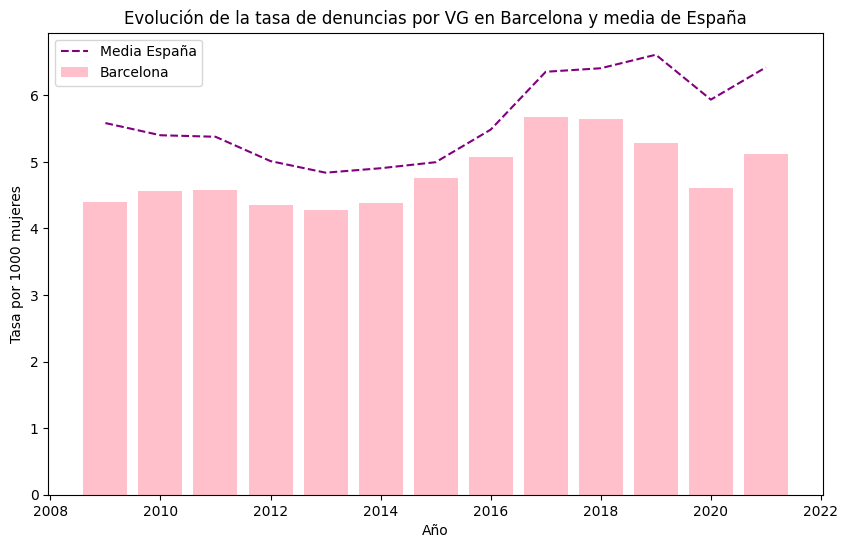

In [13]:
plot_denuncias('barcelona')

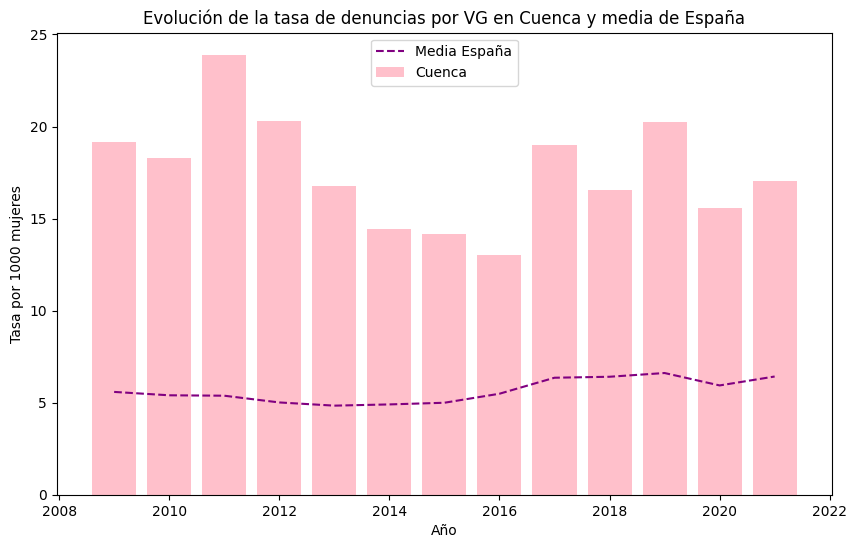

In [14]:
plot_denuncias('cuenca')

## ANALISIS LLAMADAS AL 016

In [15]:
llam.groupby('llamante')['total_llamadas'].sum()

llamante
0               16864
desconocido     34741
familiar       297942
usuaria        869482
Name: total_llamadas, dtype: int64

In [16]:
llam.describe(include='object').T

,count,unique,top,freq
trimestre,12508,4,tercero,3233
llamante,12508,4,desconocido,4452
provincia,12508,51,cuenca,472
comunidad,12508,18,castilla y leon,2124


In [17]:
llam.groupby('llamante')['total_llamadas'].sum()

llamante
0               16864
desconocido     34741
familiar       297942
usuaria        869482
Name: total_llamadas, dtype: int64

In [18]:
llam.groupby('trimestre')['total_llamadas'].sum()

trimestre
cuarto     291497
primero    285685
segundo    313793
tercero    328054
Name: total_llamadas, dtype: int64

In [19]:
llam.head()

,año,trimestre,llamante,provincia,comunidad,total_llamadas
0,2007,tercero,usuaria,almeria,andalucia,3
1,2007,tercero,familiar,almeria,andalucia,0
2,2007,tercero,desconocido,almeria,andalucia,0
3,2007,cuarto,usuaria,almeria,andalucia,150
4,2007,cuarto,familiar,almeria,andalucia,27


In [22]:
denu_filt = denu.groupby(['año', 'trimestre', 'provincia'], as_index=False)['total_denuncias'].sum()

llam_group = llam.groupby(['año', 'trimestre', 'provincia'], as_index=False)['total_llamadas'].sum()
llam_group = llam_group[llam_group['año'] >= 2009]
llam_denu = pd.merge(llam_group, denu_filt, on = ['año', 'trimestre', 'provincia'], how='left')
llam_denu.head()


,año,trimestre,provincia,total_llamadas,total_denuncias
0,2009,cuarto,alava,54,194.0
1,2009,cuarto,albacete,97,237.0
2,2009,cuarto,alicante,639,1813.0
3,2009,cuarto,almeria,204,545.0
4,2009,cuarto,asturias,384,505.0


In [24]:
corr = llam_denu[['total_llamadas', 'total_denuncias']].corr()
corr

,total_llamadas,total_denuncias
total_llamadas,1.000000,0.931771
total_denuncias,0.931771,1.000000
